In [1]:
import process_data
import NFL_eval
from NFL_eval import NFLMultipleModelsEval
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sys
import os

In [14]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated")
features = ["home_win", "relative_strength", "homeScore", "awayScore", "scoringPlay", "start.down", "start.distance", "start.yardLine", "end.down", "end.distance", "end.yardLine"]
eval = NFLMultipleModelsEval(interpolated_dir, features)

In [3]:
eval.process([2023, 2024])

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2019
Loading data for 2021
Loading data for 2020
Loading data for 2018
Done processing


In [43]:
import torch.nn as nn
import torch.nn.functional as F

# Define the feedforward neural network
class NN(nn.Module):
    def __init__(self, input_size=10, hidden_sizes=[64, 32], output_size=2):
        super(NN, self).__init__()
        
        # Dynamically create hidden layers based on the length of hidden_sizes
        self.hidden_layers = nn.ModuleList()
        
        # First hidden layer: from input_size to the first hidden layer size
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Create subsequent hidden layers: each layer is from hidden_sizes[i] to hidden_sizes[i+1]
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Output layer: from last hidden layer to output_size
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        # Pass through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Output layer (no activation function)
        return self.output(x)  # Raw logits, no sigmoid or softmax here

In [50]:
class NNModel:
    def __init__(self, epochs = 100, input_size=10, hidden_sizes=[64, 32, 16, 4], output_size=2):
        self.model = NN(input_size, hidden_sizes, output_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.epochs = epochs
    def fit(self, X, y):
        y = y.to(torch.long)  # Ensure y is of type LongTensor
        final_loss = None  # Store the last loss
        for _ in range(self.epochs):
            self.optimizer.zero_grad()
            output = self.model(X)  # Model outputs raw logits (no sigmoid/softmax needed)
            loss = self.criterion(output, y)  # y must be class indices, NOT one-hot
            loss.backward()
            self.optimizer.step()
        final_loss = loss.item()  # Store loss as a Python number
        print(f"Final Loss: {final_loss}")  # Output the last loss after training
    def score(self, X_test, y_test):
        self.model.eval()
        # Convert y_test to tensor
        y_test = torch.tensor(y_test, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
            logits = self.model(X_test)               # [N, 2]
            probs = F.softmax(logits, dim=1)     # [N, 2]
            y_pred = probs[:, 1]                 # Probabilities for class 1
            ss_res = torch.sum((y_test - y_pred) ** 2)
            ss_tot = torch.sum((y_test - torch.mean(y_test)) ** 2)
            r2 = 1 - ss_res / ss_tot
            return r2.item()
    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X)
            return F.softmax(logits, dim=1)  # Convert to probabilities


In [14]:
import importlib
importlib.reload(process_data)
importlib.reload(NFL_eval)

<module 'NFL_eval' from '/Users/aly/Documents/University of Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/notebooks/NFL_eval.py'>

In [51]:
eval.train_DL(NNModel, epochs=100, input_size=10)

Training for timestep 0.0
Final Loss: 0.6882255673408508
Training for timestep 0.005
Final Loss: 0.6786202788352966
Training for timestep 0.01
Final Loss: 0.6781750917434692
Training for timestep 0.015
Final Loss: 0.6777135133743286
Training for timestep 0.02
Final Loss: 0.6770578622817993
Training for timestep 0.025
Final Loss: 0.6579598784446716
Training for timestep 0.03
Final Loss: 0.6796165704727173
Training for timestep 0.035
Final Loss: 0.6729980111122131
Training for timestep 0.04
Final Loss: 0.6801691055297852
Training for timestep 0.045
Final Loss: 0.670890212059021
Training for timestep 0.05
Final Loss: 0.6878408789634705
Training for timestep 0.055
Final Loss: 0.676588237285614
Training for timestep 0.06
Final Loss: 0.6742432117462158
Training for timestep 0.065
Final Loss: 0.6773552298545837
Training for timestep 0.07
Final Loss: 0.6845139861106873
Training for timestep 0.075
Final Loss: 0.6719295978546143
Training for timestep 0.08
Final Loss: 0.6658551096916199
Training 

In [52]:
eval.evaluate([2023, 2024])

Loading data for 2022
Loading data for 2024


KeyboardInterrupt: 

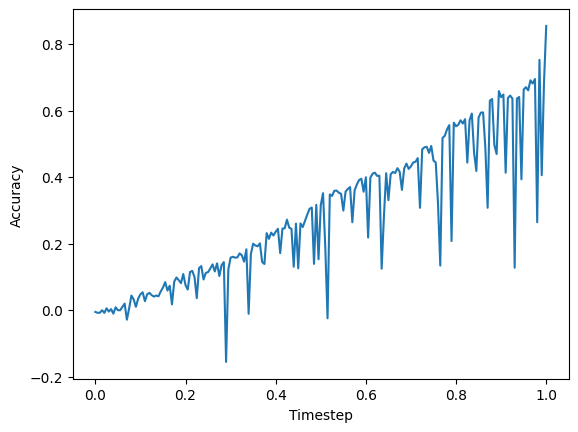

In [53]:
eval.plot()